In [4]:
%matplotlib inline
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
start = dt.datetime.now()

In [7]:
os.listdir(r"C:\Users\CANARA BANK\Desktop\keras-pretrained-models")

['imagenet_class_index.json',
 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels.h5',
 'inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'inception_v3_weights_tf_dim_ordering_tf_kernels.h5',
 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'Kuszma.JPG',
 'resnet50_weights_tf_dim_ordering_tf_kernels.h5',
 'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
 'xception_weights_tf_dim_ordering_tf_kernels.h5',
 'xception_weights_tf_dim_ordering_tf_kernels_notop.h5']

In [8]:
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)


In [9]:
os.listdir(r"C:\Users\CANARA BANK\Desktop\Data")

['.ipynb_checkpoints',
 'plant-seedlings-classification.zip',
 'sample_submission.csv',
 'test',
 'train',
 'Untitled.ipynb']

In [10]:
CATEGORIES = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Scentless Mayweed',
              'Maize', 'Loose Silky-bent' , 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
NUM_CATEGORIES = len(CATEGORIES)

In [11]:
SAMPLE_PER_CATEGORY = 200
SEED = 1987
data_dir = r"C:\Users\CANARA BANK\Desktop\Data"
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
sample_submission = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))

In [12]:
sample_submission.head(2)

,file,species
0,0021e90e4.png,Sugar beet
1,003d61042.png,Sugar beet


In [13]:
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(train_dir, category)))))

Black-grass 263 images
Charlock 390 images
Cleavers 287 images
Common Chickweed 611 images
Common wheat 221 images
Fat Hen 475 images
Scentless Mayweed 654 images
Maize 221 images
Loose Silky-bent 516 images
Shepherds Purse 231 images
Small-flowered Cranesbill 496 images
Sugar beet 385 images


In [14]:
train = []
for category_id, category in enumerate(CATEGORIES):
    for file in os.listdir(os.path.join(train_dir, category)):
        train.append(['train/{}/{}'.format(category, file), category_id, category])
train = pd.DataFrame(train, columns=['file', 'category_id', 'category'])
train.head(2)
train.shape

,file,category_id,category
0,train/Black-grass/0050f38b3.png,0,Black-grass
1,train/Black-grass/0183fdf68.png,0,Black-grass


(4750, 3)

In [15]:
print("Training Sample")

Training Sample


In [16]:
train = pd.concat([train[train['category'] == c][:SAMPLE_PER_CATEGORY] for c in CATEGORIES])
train = train.sample(frac=1)
train.index = np.arange(len(train))
train.head(2)
train.shape


,file,category_id,category
0,train/Black-grass/7e1bf9449.png,0,Black-grass
1,train/Maize/e364ace75.png,7,Maize


(2400, 3)

In [17]:
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test = pd.DataFrame(test, columns=['filepath', 'file'])
test.head(2)
test.shape

,filepath,file
0,test/0021e90e4.png,0021e90e4.png
1,test/003d61042.png,003d61042.png


(794, 2)

In [18]:
#Function to read images
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_dir, filepath), target_size=size)
    img = image.img_to_array(img)
    return img

In [19]:
print("Example images")

Example images


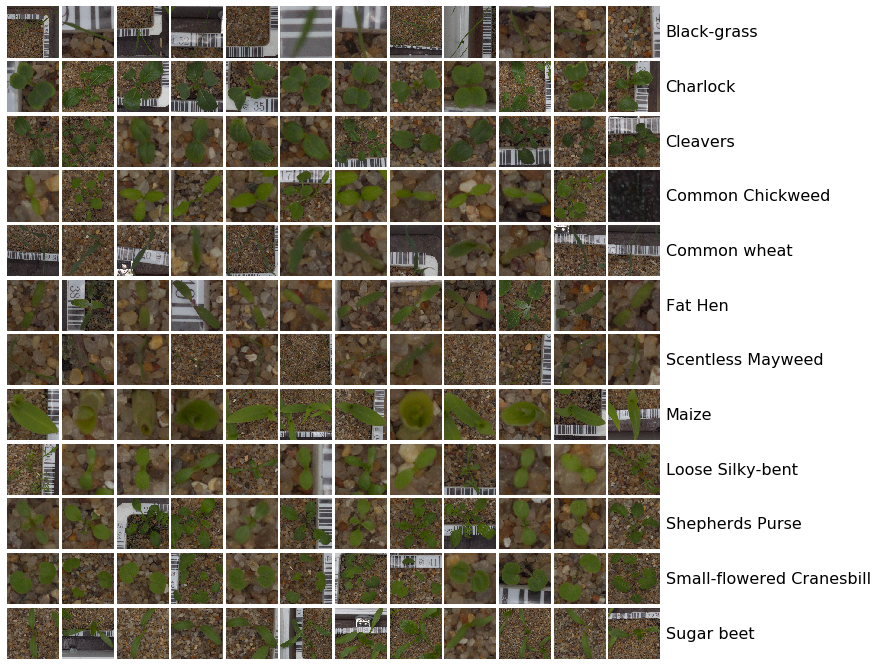

In [20]:
fig = plt.figure(1, figsize=(NUM_CATEGORIES, NUM_CATEGORIES))
grid = ImageGrid(fig, 111, nrows_ncols=(NUM_CATEGORIES, NUM_CATEGORIES), axes_pad=0.05)
i = 0
for category_id, category in enumerate(CATEGORIES):
    for filepath in train[train['category'] == category]['file'].values[:NUM_CATEGORIES]:
        ax = grid[i]
        img = read_img(filepath, (224, 224))
        ax.imshow(img / 255.)
        ax.axis('off')
        if i % NUM_CATEGORIES == NUM_CATEGORIES - 1:
            ax.text(250, 112, filepath.split('/')[1], verticalalignment='center')
        i += 1
plt.show();

In [21]:
print("Validation split")

Validation split


In [22]:
np.random.seed(seed=SEED)
rnd = np.random.random(len(train))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
ytr = train.loc[train_idx, 'category_id'].values
yv = train.loc[valid_idx, 'category_id'].values
len(ytr), len(yv)

(1899, 501)

In [23]:
print("Extract bottleneck features")

Extract bottleneck features


In [24]:
INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(train), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, file in tqdm(enumerate(train['file'])):
    img = read_img(file, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

2400it [01:37, 24.54it/s]

Train Images shape: (2400, 299, 299, 3) size: 643,687,200


In [25]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((1899, 299, 299, 3), (501, 299, 299, 3), (1899,), (501,))
501/501 [==============================] - 200s 399ms/sample
Xception train bottleneck features shape: (1899, 2048) size: 3,889,152
Xception valid bottleneck features shape: (501, 2048) size: 1,026,048


In [26]:
print("LogReg on Xception Bottleneck features")

LogReg on Xception Bottleneck features


In [27]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.max_iter=1000

logreg.fit(train_x_bf, ytr)
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=1987, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
print('Validation Xception Accuracy {}'.format(accuracy_score(yv, valid_preds)))


Validation Xception Accuracy 0.8403193612774451


In [29]:
print("Random forrest reg on Xception Bottleneck features")

Random forrest reg on Xception Bottleneck features


In [30]:
import sklearn.ensemble
ranfor=sklearn.ensemble.RandomForestClassifier(n_estimators=10)
ranfor.fit(train_x_bf, ytr)
ranfor_valid_preds=ranfor.predict(valid_x_bf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
print('Validation Xception Accuracy for random forest {}'.format(accuracy_score(yv, ranfor_valid_preds)))


Validation Xception Accuracy for random forest 0.6067864271457086


In [32]:
print("Confusion matrix")
cnf_matrix = confusion_matrix(yv, valid_preds)

Confusion matrix


In [33]:
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': CATEGORIES, 'abbreviation': abbreviation})

,class,abbreviation
0,Black-grass,BG
1,Charlock,Ch
2,Cleavers,Cl
3,Common Chickweed,CC
4,Common wheat,CW
5,Fat Hen,FH
6,Scentless Mayweed,LSB
7,Maize,M
8,Loose Silky-bent,SM
9,Shepherds Purse,SP


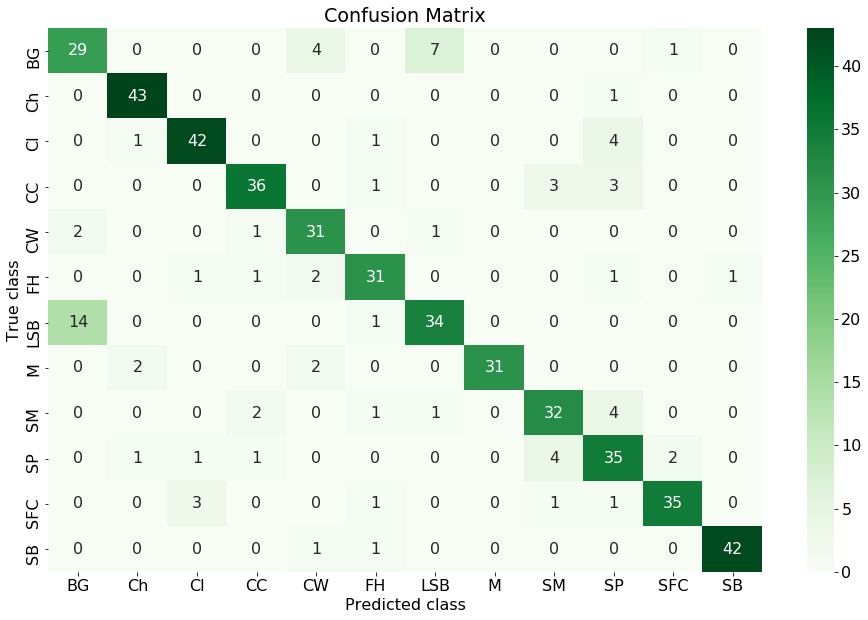

In [34]:
fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

In [35]:
print("Create Submission")

Create Submission


In [36]:
x_test = np.zeros((len(test), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, filepath in tqdm(enumerate(test['filepath'])):
    img = read_img(filepath, (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_test[i] = x
print('test Images shape: {} size: {:,}'.format(x_test.shape, x_test.size))

794it [00:15, 50.38it/s]

test Images shape: (794, 299, 299, 3) size: 212,953,182


In [37]:
test_x_bf = xception_bottleneck.predict(x_test, batch_size=32, verbose=1)
print('Xception test bottleneck features shape: {} size: {:,}'.format(test_x_bf.shape, test_x_bf.size))
test_preds = logreg.predict(test_x_bf)

794/794 [==============================] - 292s 367ms/sample
Xception test bottleneck features shape: (794, 2048) size: 1,626,112


In [38]:
test['category_id'] = test_preds
test['species'] = [CATEGORIES[c] for c in test_preds]
test[['file', 'species']].to_csv('submission.csv', index=False)

In [39]:
end = dt.datetime.now()
print('Total time {} s.'.format((end - start).seconds))
print('We almost used the one hour time limit.')


Total time 1594 s.
We almost used the one hour time limit.
